# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle


%matplotlib inline
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 100
plt.style.use('default')
plt.style.use('ggplot')

In [2]:
# Libs for part IV: Content Based Recommendations
import re

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()
snowball = SnowballStemmer('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abitf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abitf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abitf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Load data
df = pd.read_csv('data/user-item-interactions.csv', index_col=0)
df_content = pd.read_csv('data/articles_community.csv', index_col=0)

In [4]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [5]:
# Show df info to get an idea of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45993 entries, 0 to 47581
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.4+ MB


In [6]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
3,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAV...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0
5,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data science: A ...,"See the forest, see the trees. Here lies the challenge in both performing and presenting an anal...",Communicating data science: A guide to presenting your work,Live,1
7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Paths\r\n * Courses * Our Courses\r\n * Partner Co...,Here’s this week’s news in Data Science and Big Data.,"This Week in Data Science (April 18, 2017)",Live,2
8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCALE - BOOST THE PERFORMANCE OF YOUR\r\nDISTRIBUTED ...","Learn how distributed DBs solve the problem of scaling persistent storage, but introduce latency...",DataLayer Conference: Boost the performance of your distributed database,Live,3
12,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAV...",This video demonstrates the power of IBM DataScience Experience using a simple New York State Re...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [7]:
# Show df_content info to get an idea of the data
df_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056 entries, 3 to 3281
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 49.5+ KB


In [8]:
# Functions for memory usage optimization

def resize_df(df):
    '''
    INPUT:
    df - (pandas dataframe) any df
    
    OUTPUT:
    df - (pandas dataframe) df with optimized columns
    '''
    cols = df.select_dtypes(['number']).columns.tolist()
    for col in cols:
        downcast = 'float'
        summ, var = df.loc[:, col].sum(), df.loc[:, col].var()
        downsized = df.loc[:, col].astype('int')
        if summ == downsized.sum() and var == downsized.var():
            downcast = 'unsigned' if df.loc[:, col].min() >= 0 else 'signed'

        df[col] = pd.to_numeric(df.loc[:, col], downcast=downcast)
    return df


def resize_column(series):
    '''
    INPUT:
    series - (pandas series) any series (column)
    
    OUTPUT:
    series - (pandas series) series (column) of optimized size for unstacking
    '''
    downcast = 'float'
    summ, var = series.sum(), series.var()
    for dtype in ['Int8', 'Int16', 'Int32', 'Int64']:
        downsized = series.astype(dtype)
        if summ == downsized.sum() and var == downsized.var():
            return downsized
    downsized = pd.to_numeric(series, downcast=downcast)
    return downsized

In [9]:
# Optimizing df
df = resize_df(df)
df_content = resize_df(df_content)

In [10]:
# Checking squezeed size
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45993 entries, 0 to 47581
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  uint16
 1   title       45993 non-null  object
 2   email       45976 non-null  object
dtypes: object(2), uint16(1)
memory usage: 1.1+ MB


In [11]:
# Checking squezeed size
df_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056 entries, 3 to 3281
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   uint16
dtypes: object(4), uint16(1)
memory usage: 43.3+ KB


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [12]:
df_groupped = df[['article_id', 'email']].groupby(['article_id'])['email'].count()
# article_id and number of users interacted with it
df_groupped.sort_values(ascending=False)[:1]

article_id
1429    937
Name: email, dtype: int64

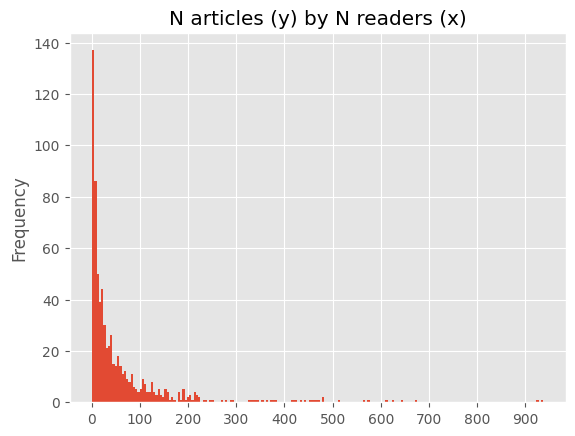

In [13]:
# Grouping by articles, count users interactions
df_groupped.plot(kind='hist', title='N articles (y) by N readers (x)', bins=200, xticks=np.arange(0, 1000, 100));

In [14]:
df_groupped = df.groupby('email')['article_id'].count()
df_groupped.quantile(.5)

3.0

In [15]:
df_groupped.mean()

8.930846930846931

In [16]:
df_groupped.sort_values(ascending=False)[0]

364

In [17]:
# Fill in the median and maximum number of user_article interactios below
median_val = int(df_groupped.quantile(.5))# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df_groupped.sort_values(ascending=False)[0]# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [18]:
df_content['article_id'].duplicated().sum()

5

In [19]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.loc[~df_content['article_id'].duplicated()]
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [20]:
# a. The number of unique articles that have an interaction with a user.
unique_articles = df['article_id'].nunique()
unique_articles

714

In [21]:
# b. The number of unique articles in the dataset (whether they have any interactions or not).
total_articles = df_content['article_id'].nunique()
total_articles

1051

In [22]:
# c. The number of unique users in the dataset. (excluding null values)
unique_users = df['email'].nunique()
unique_users

5148

In [23]:
# d. The number of user-article interactions in the dataset.
user_article_interactions = df.shape[0]
user_article_interactions

45993

In [24]:
unique_articles = df['article_id'].nunique()# The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()# The number of unique articles on the IBM platform
unique_users = df['email'].nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [25]:
interactions_groupped = df[['article_id', 'email']].groupby('article_id')['email'].count()
most_viewed = interactions_groupped[interactions_groupped > 0].sort_values(ascending=False).reset_index().iloc[0]
most_viewed

article_id    1429.0
email          937.0
Name: 0, dtype: float64

In [26]:
most_viewed['article_id'].astype('str')

'1429.0'

In [27]:
most_viewed['email'].astype('int')

937

In [28]:
most_viewed_article_id = most_viewed['article_id'].astype('str')# The most viewed article in the dataset as a string with one value following the decimal 
max_views = most_viewed['email'].astype('int')# The most viewed article in the dataset was viewed how many times?

In [29]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [30]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [31]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('article_id').agg({'title': 'max', 'user_id': 'count'}).sort_values(by=['user_id', 'title'], ascending=[False, True]).iloc[:n]['title'].tolist()
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('article_id').agg({'title': 'max', 'user_id': 'count'}).sort_values(by=['user_id', 'title'], ascending=[False, True]).iloc[:n].index.tolist()
    return top_articles # Return the top article ids

In [32]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [33]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [34]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df_c = df.copy()
    df_c['count'] = 1
    df_c['count'] = df_c['count'].astype('int8')
    user_item = df_c[['user_id', 'article_id', 'count']].groupby(['user_id', 'article_id'])['count'].max().unstack(fill_value=0)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [35]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [36]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    most_similar_users = []
    if user_id in user_item.index:
        user_item_c = user_item.copy()
        # compute similarity of each user to the provided user
        user_item_c['similarity'] = np.sum(user_item_c * user_item_c.loc[user_id], axis=1)
        
        # remove the own user's id & sort by similarity
        user_item_c = user_item_c.drop(user_id)
        user_mat = user_item_c.sort_values(['similarity'], ascending=False)

        # create list of just the ids
        most_similar_users = user_mat.index.tolist()
   
    return most_similar_users # return a list of the users in order from most to least similar

In [37]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [38]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    articles = df.loc[:, ['article_id', 'title']].groupby('article_id')['title'].max().reset_index()
    article_names = articles.loc[articles['article_id'].isin(article_ids), 'title'].values.tolist()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids, article_names = [], []
    if user_id in user_item.index:
        article_ids = user_item.columns[user_item.loc[user_id] > 0].tolist()
        article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    user_interest = user_item.loc[user_id]
    close_users = find_similar_users(user_id)
    recs = set()
    for close_user in close_users:
        if len(recs) >= m:
            break
        unseen = user_item.loc[close_user] - user_interest
        recs.update(unseen[unseen > 0].index.tolist())
    recs = list(recs)[:m]
    return recs # return your recommendations for this user_id    

In [39]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'shaping data with ibm data refinery',
 'data science platforms are on the rise and ibm is leading the way',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values']

In [40]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [41]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbors_df = pd.DataFrame({'neighbor_id': user_item.index})
    # compute similarity of each user to the provided user
    user_articles = user_item.loc[user_id] if user_id in user_item.index else np.zeros(user_item.shape[1])
    neighbors_df['similarity'] = user_item.dot(user_articles).values
    # compute num_interactions of each user
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: df[df['user_id']==x].shape[0])
    # remove target user
    neighbors_df = neighbors_df[neighbors_df['neighbor_id']!=user_id]
    # sort by similarity and num_interactions
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])
    # reset index after sorting
    neighbors_df = neighbors_df.reset_index(drop=True)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs, rec_names = [], []
    user_articles = get_user_articles(user_id)[0]
    neighbors_df = get_top_sorted_users(user_id)
    for idx, row in neighbors_df.iterrows():
        neighbor_articles = get_user_articles(row['neighbor_id'])[0]
        neighbor_articles_sorted = df.loc[df['article_id'].isin(neighbor_articles), ['article_id', 'user_id']].groupby('article_id')['user_id'].count().sort_values(ascending=False).index.tolist()
        new_recs = list(set(neighbor_articles_sorted) - set(user_articles) - set(recs))
        recs.extend(new_recs)
        if len(recs) >= m:
            break
    recs = recs[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [42]:
user_id = 131
df_c = get_top_sorted_users(user_id)
df_c.head()

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,203,33,160
4,4459,33,158


In [43]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1024, 12, 1296, 1304, 793, 555, 1324, 302, 1329, 1330]

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'accelerate your workflow with dsx', 'build a naive-bayes model with wml & dsx', '10 powerful features on watson data platform, no coding necessary', 'using deep learning to reconstruct high-resolution audio', 'fortune 100 companies', 'gosales transactions for logistic regression model', 'ibm watson facebook posts for 2015', 'ingest data from message hub in a streams flow', 'insights from new york car accident reports']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [44]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[:1]['neighbor_id'].values[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9:10]['neighbor_id'].values[0]# Find the 10th most similar user to user 131

In [45]:
user1_most_sim, user131_10th_sim

(3933, 242)

In [46]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


In [47]:
top_10_users_for_user_131 = get_top_sorted_users(131).iloc[:10]
top_10_users_for_user_131

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,203,33,160
4,4459,33,158
5,98,29,170
6,3764,29,169
7,49,29,147
8,3697,29,145
9,242,25,148


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

In [48]:
user_user_recs_part2(0, 10)

([1025, 2, 517, 12, 524, 14, 16, 26, 1051, 1052],
 ['this week in data science (april 18, 2017)',
  'timeseries data analysis of iot events by using jupyter notebook',
  'got zip code data? prep it for analytics. – ibm watson data lab – medium',
  'higher-order logistic regression for large datasets',
  'using machine learning to predict parking difficulty',
  'shaping data with ibm data refinery',
  'data science platforms are on the rise and ibm is leading the way',
  'data tidying in data science experience',
  'a tensorflow regression model to predict house values',
  'access db2 warehouse on cloud and db2 with python'])

The new user will have 0 interactions and 0 similarity with any other user in the database. This means he will have the same number of interactions and the same similarity with any other user and will get random recommendations. So the best way to recommend articles for new users is to provide the top articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [49]:
new_user = 0

# What would your recommendations be for this new user '0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [50]:
assert set(new_user_recs) == set([1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [51]:
# Difference of article ids between df and df_content
different = list(set(df['article_id'].unique()).difference(df_content['article_id'].unique()))
len(different)

277

In [52]:
# Prepare df for concat
df_articles = df.loc[df['article_id'].isin(different), ['article_id', 'title']].groupby('article_id')['title'].max().reset_index()
df_articles = df_articles.rename({'title': 'doc_full_name'}, axis=1)
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     277 non-null    uint64
 1   doc_full_name  277 non-null    object
dtypes: object(1), uint64(1)
memory usage: 4.5+ KB


In [53]:
# Prepare df_content for concat
df_content_articles = df_content.loc[:, df_content.columns.drop('doc_status')]
df_content_articles.shape

(1051, 4)

In [54]:
# Concat dataframes
df_articles = pd.concat([df_content_articles, df_articles], axis=0, ignore_index=True)
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1037 non-null   object
 1   doc_description  1048 non-null   object
 2   doc_full_name    1328 non-null   object
 3   article_id       1328 non-null   uint64
dtypes: object(3), uint64(1)
memory usage: 41.6+ KB


In [55]:
# Handle nulls
df_articles = df_articles.fillna('')
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1328 non-null   object
 1   doc_description  1328 non-null   object
 2   doc_full_name    1328 non-null   object
 3   article_id       1328 non-null   uint64
dtypes: object(3), uint64(1)
memory usage: 41.6+ KB


In [56]:
def tokenize(text, use_stop_words=True, use_lemmatization=True, use_stemming=False):
    '''
    INPUT:
    text (str) - text to tokenize
    use_stop_words (bool) - use dictionary with stop words
    use_lemmatization (bool) - use lemmatization
    use_stemming (bool) - use stemming
    OUTPUT:
    tokens (list) - processed text
    '''
    text = text.lower()
    # Filter symbols '\n' and '\r'
    text = re.sub(r'\\r|\\n', ' ', text)
    # Filter urls
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'url_placeholder', text)
    # Filter all non-alphanumeric symbols
    text = re.sub(r'[^\b\w\b\\]+', ' ', text)
    tokens = word_tokenize(text)
    if use_stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    if use_lemmatization:
        tokens = [wnl.lemmatize(word) for word in tokens]
    if use_stemming:
        tokens = [snowball.stem(word) for word in tokens]
    return tokens

In [57]:
# Initialization of TfidfVectorizer
vect = TfidfVectorizer(lowercase=True, token_pattern=r'\b\w+\b', stop_words='english', max_df=0.5, min_df=0.001, tokenizer=tokenize)

In [58]:
# Fitting data and transforming to document-term matrix
X = vect.fit_transform(df_articles['doc_full_name'] + '\n' + df_articles['doc_description'] + '\n' + df_articles['doc_body'])
X.shape

C:\Program Files\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  warnings.warn(


(1328, 14164)

In [59]:
# Construct pandas DataFrame from document-term matrix
df_content_mat = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out(), index=df_articles['article_id'].values)
df_content_mat.shape

(1328, 14164)

In [60]:
# Inspect the df
df_content_mat.head()

,0,00,000,0000,00000,000000,0000000,0000000000000000,00001,0001,...,à,óskarsdóttir,μμμ,σ,τ,русский,العربية,ツ,中文,日本語
0,0.0,0.048835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.023412,0.0,0.023412,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [61]:
target_article = 1427
most_similar = (df_content_mat.drop(index=[target_article]) * df_content_mat.loc[target_article,:]).sum(axis=1).sort_values(ascending=False)[:10]
most_similar

1175    0.409680
1298    0.306766
805     0.287103
384     0.273561
30      0.271461
685     0.248486
253     0.226253
1035    0.225411
800     0.223906
655     0.223772
dtype: float64

In [62]:
# Check with target article
df_articles.loc[df_articles['article_id'].isin(most_similar.index.to_list() + [target_article]), 'doc_full_name']

30                       How open API economy accelerates the growth of big data and analytics
253     Lifelong (machine) learning: how automation can help your models get smarter over time
384                                                              Continuous Learning on Watson
655                                        Create a project for Watson Machine Learning in DSX
685                                            Working with data flows using  Watson Data APIs
800                                                        Machine Learning for the Enterprise
805                                                              Machine Learning for everyone
1035                                                      Machine Learning for the Enterprise.
1145                                      breast cancer detection with xgboost, wml and scikit
1219                                          from scikit-learn model to cloud with wml client
1311                              use xgboost, sci

In [63]:
def get_content_rec(id, df_content_mat=df_content_mat):
    '''Find the maximum value in result of vector multiplication of TfIdf matrix rows (without target document) and target document
    '''
    return (df_content_mat.drop(index=[id]) * df_content_mat.loc[id,:]).sum(axis=1).sort_values(ascending=False) if id in df_content_mat.index else []

In [64]:
def get_content_article_names(ids, df_articles=df_articles):
    '''Get the article names from df_articles
    '''
    return df_articles.loc[df_articles['article_id'].isin(ids), 'doc_full_name'].values.tolist()

In [65]:
def make_content_recs(id, n=10, is_article_id=True, df_content_mat=df_content_mat):
    '''
    INPUT:
    id (int) - id of user/article
    n (int) - number of recommendations
    is_article_id (bool) - is this article id (True) or user id (False)
    df_content_mat (pandas DataFrame) - matrix with TfIdf values of tokens
    OUTPUT:
    ids (list) - list of recommended article ids
    titles (list) - list of recommended article titles
    '''
    ids, titles = [], []
    content_recs = pd.Series(dtype='float64')
    if is_article_id:
        content_recs = get_content_rec(id, df_content_mat)
    else:
        # Is user_id
        article_ids, _ = get_user_articles(id)
        if not len(article_ids):
            # New user
            ids = get_top_article_ids(n)
            titles = get_content_article_names(ids)
            return ids, titles
        content_recs = get_content_rec(article_ids[0])[:n]
        for i in range(1, len(article_ids)):
            content_recs_next_article = get_content_rec(article_ids[i])[:n]
            content_recs = pd.concat([content_recs, content_recs_next_article], axis=0)
        content_recs = content_recs.sort_index()
        content_recs = content_recs.groupby(content_recs.index).max().sort_values(ascending=False)
    ids = content_recs[:n].index.tolist()
    titles = get_content_article_names(ids)
    return ids, titles

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

The system recommends articles based on the user's actions (read) on the articles. It provides the most similar articles by searching for common words. 
If it's a brand new user than the system doesn't have any recommendations and returns top articles. 

Content based recommendation system uses TfIdf matrix of articles' tokens. Tokens are separate words in each document (article) filtered by English stop words and lemmatized. Then tokens that appear in less than 0.1% or in more than 50% of documents are dropped. 

The minimum threshold of 0.1% is based on that if word is only appeared in single document then the system will fail to find another document containing this word and right now there are 1328 unique titles in the database and that is 1328*0.001=1.328. 
The maximum threshold of 50% is based on too high frequency use of a word as it has little meaning on its own.

Possible improvements are:

    1. Add more stop words dictionaries as there are words in other languages.
    2. Use n-grams tokens.
    3. Tune better filtering to get rid of such tokens like: "00, 000, 0000, 00000, 000000, 0000000, 0000000000000000..."

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [66]:
# make recommendations for a brand new user
new_user_recs = make_content_recs(id=9999, n=10, is_article_id=False)

# make a recommendations for a user who only has interacted with article id '1427.0'
article_1427_recs = make_content_recs(id=1427, n=10, is_article_id=True)

print('Brand new user recommendations:\n', '\nArticle ids:\n', new_user_recs[0], '\n', '\nArticle titles:\n', new_user_recs[1])
print('\n')
print('Recommendations based on interaction with article id 1427:\n',\
        '\nArticle title:\n', get_article_names([1427]),\
        '\nArticle ids:\n', article_1427_recs[0],\
        '\n',\
        '\nArticle titles:\n', article_1427_recs[1])

Brand new user recommendations:
 
Article ids:
 [1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304] 
 
Article titles:
 ['analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'finding optimal locations of new store using decision optimization', 'gosales transactions for logistic regression model', 'healthcare python streaming application demo', 'insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'use deep learning for image classification', 'visualize car data with brunel']


Recommendations based on interaction with article id 1427:
 
Article title:
 ['use xgboost, scikit-learn & ibm watson machine learning apis'] 
Article ids:
 [1175, 1298, 805, 384, 30, 685, 253, 1035, 800, 655] 
 
Article titles:
 ['How open API economy accelerates the growth of big data and analytics', 'Lifelong (machine) learning: how automation can help your

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [67]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [68]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
user_item_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5149 entries, 1 to 5149
Columns: 714 entries, 0.0 to 997.0
dtypes: float64(714)
memory usage: 28.1 MB


In [70]:
# Optimize memory usage
user_item_matrix = resize_df(user_item_matrix)
user_item_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5149 entries, 1 to 5149
Columns: 714 entries, 0.0 to 997.0
dtypes: uint8(714)
memory usage: 3.5 MB


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [71]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

Here we do have true zero values (ratio measurement level) which give us useful information on that user haven't yet interacted with the article and we can use this as similarity with neighbors.

While in the movie matrix values are ordinal and [0, na] show absence of observation (rating) and that doesn't give any useful information for similarity with neighbors, and we can only predict it.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

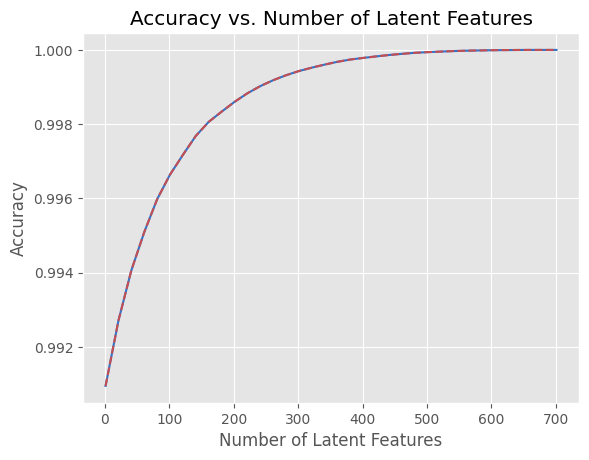

In [72]:
num_latent_feats = np.arange(1,700+10,20)
sum_errs = []
acc = []
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    # using (tp + tn) / (tp + tn + fp + fn) accuracy formula to check
    # that 1 - np.array(sum_errs)/user_item_matrix.size is the same
    # and not the same as 1 - np.array(sum_errs)/df.shape[0]
    tp = np.where(user_item_matrix + user_item_est == 2, 1, 0).sum()
    tn = np.where(user_item_matrix + user_item_est == 0, 1, 0).sum()
    fp = np.where(user_item_matrix - user_item_est == 1, 1, 0).sum()
    fn = np.where(user_item_matrix - user_item_est == -1, 1, 0).sum()
    acc.append((tp + tn) / (tp + tn + fp + fn))
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/user_item_matrix.size, c='b')
plt.plot(num_latent_feats, acc, linestyle='dashed', c='r')
# plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [73]:
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [74]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [75]:
# Data disbalance
user_item_train.sum().sum() / user_item_train.size

0.009134386984122823

In [76]:
# Data disbalance
user_item_test.sum().sum() / user_item_test.size

0.011354695658393534

In [77]:
user_item_train.shape, user_item_test.shape, len(test_idx), len(test_arts)

((4487, 714), (682, 574), 682, 574)

In [78]:
# Can make prediction for this amount of users
users_for_prediction = set(user_item_test.index.tolist()).intersection(user_item_train.index.tolist())
len(users_for_prediction)

20

In [79]:
# Can't make prediction for this amount of users
user_item_test.shape[0] - len(users_for_prediction)

662

In [80]:
# Can make prediction for this amount of articles
articles_for_prediction = set(user_item_test.columns.tolist()).intersection(user_item_train.columns.tolist())
len(articles_for_prediction)

574

In [81]:
# Can't make prediction for this amount of articles
user_item_test.shape[1] - len(articles_for_prediction)

0

In [82]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [83]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [84]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [85]:
def get_elem_index(arr, val):
    '''
    INPUT:
    arr (list) - list/array where to search
    val (any) - any value to search for
    
    OUTPUT:
    index of element (val) in list (arr)
    '''
    found = np.where(arr == val)
    if not np.isscalar(found) and len(found[0]):
        return found[0][0]
    return None


def get_elems_indexes(arr, vals):
    '''
    INPUT:
    arr (list) - list/array where to search
    vals (any) - any values to search for
    
    OUTPUT:
    list with indexes of elements (vals) in list (arr)
    '''
    indexes = []
    for val in vals:
        index = get_elem_index(arr, val)
        indexes.append(index)
    return indexes

In [86]:
# Get indexes of user ids
users_ids = get_elems_indexes(user_item_train.index, users_for_prediction)

In [87]:
# Get indexes of articles ids
articles_ids = get_elems_indexes(user_item_train.columns, articles_for_prediction)

In [88]:
# Check ids and their found indexes
assert np.array_equal(np.array(user_item_train.iloc[users_ids, articles_ids]), np.array(user_item_train.loc[users_for_prediction, articles_for_prediction]))

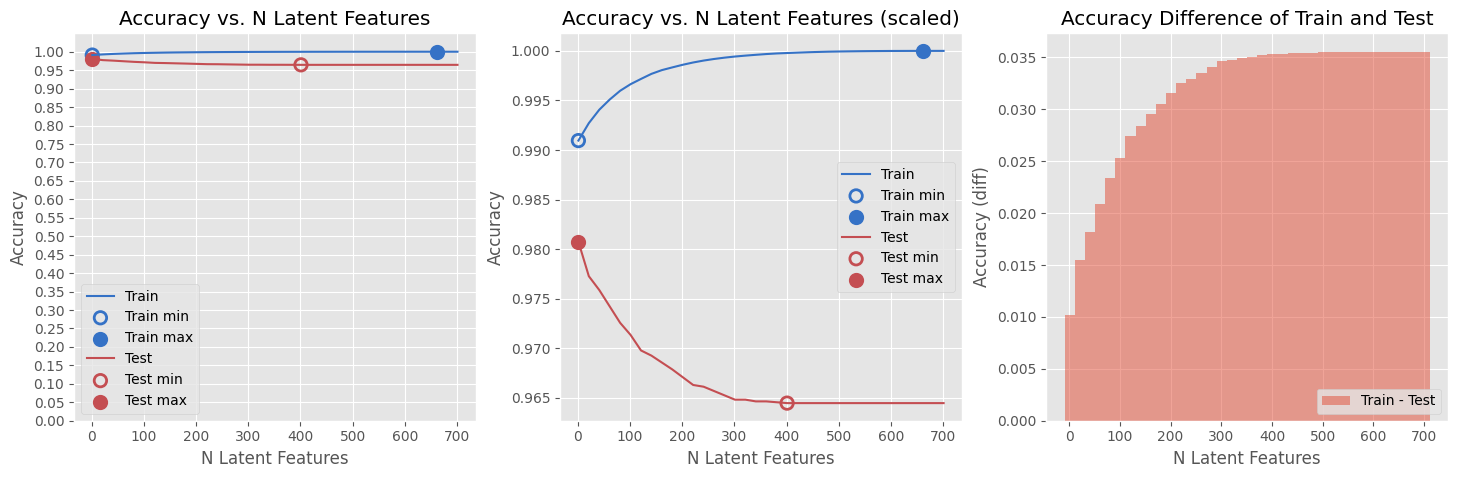

The lowest accuracy of 99.09% on the train set was achieved with 1 latent features.
The highest accuracy of 100.00% on the train set was achieved with 661 latent features.
The lowest accuracy of 96.45% on the test set was achieved with 401 latent features.
The highest accuracy of 98.07% on the test set was achieved with 1 latent features.


In [89]:
# Taking subset of rows in the user_item_test dataset
sub_test = user_item_test.loc[users_for_prediction, articles_for_prediction]

sum_errs_test = []
for k in num_latent_feats:
    # take dot product
    sub_train_prediction = np.around(np.dot(np.dot(u_train[users_ids, :k], np.diag(s_train[:k])), vt_train[:k, articles_ids]))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(sub_train_prediction, sub_test)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs_test.append(err)
    

train_accs = 1 - np.array(sum_errs) / user_item_matrix.size
test_accs = 1 - np.array(sum_errs_test) / sub_test.size

train_stats = {
    'minimum': min(train_accs),
    'maximum': max(train_accs),
    'min_feats': num_latent_feats[np.argmin(train_accs)],
    'max_feats': num_latent_feats[np.argmax(train_accs)]
}

test_stats = {
    'minimum': min(test_accs),
    'maximum': max(test_accs),
    'min_feats': num_latent_feats[np.argmin(test_accs)],
    'max_feats': num_latent_feats[np.argmax(test_accs)]
}

fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
fig.tight_layout(pad=3.0)

axes[0].plot(num_latent_feats, train_accs, label='Train', c='b')
axes[0].scatter(train_stats['min_feats'], train_stats['minimum'], label='Train min', edgecolors='b', facecolors='none', linewidth=2, s=80)
axes[0].scatter(train_stats['max_feats'], train_stats['maximum'], label='Train max', edgecolors='b', facecolors='b', linewidth=2, s=80)
axes[0].plot(num_latent_feats, test_accs, label='Test', c='r')
axes[0].scatter(test_stats['min_feats'], test_stats['minimum'], label='Test min', edgecolors='r', facecolors='none', linewidth=2, s=80)
axes[0].scatter(test_stats['max_feats'], test_stats['maximum'], label='Test max', edgecolors='r', facecolors='r', linewidth=2, s=80)

axes[1].plot(num_latent_feats, train_accs, label='Train', c='b')
axes[1].scatter(train_stats['min_feats'], train_stats['minimum'], label='Train min', edgecolors='b', facecolors='none', linewidth=2, s=80)
axes[1].scatter(train_stats['max_feats'], train_stats['maximum'], label='Train max', edgecolors='b', facecolors='b', linewidth=2, s=80)
axes[1].plot(num_latent_feats, test_accs, label='Test', c='r')
axes[1].scatter(test_stats['min_feats'], test_stats['minimum'], label='Test min', edgecolors='r', facecolors='none', linewidth=2, s=80)
axes[1].scatter(test_stats['max_feats'], test_stats['maximum'], label='Test max', edgecolors='r', facecolors='r', linewidth=2, s=80)

axes[2].bar(num_latent_feats, train_accs-test_accs, 20, label='Train - Test', alpha=0.5)

axes[0].set_xlabel('N Latent Features')
axes[1].set_xlabel('N Latent Features')
axes[2].set_xlabel('N Latent Features')
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Accuracy')
axes[2].set_ylabel('Accuracy (diff)')
axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='lower right')
axes[0].set_yticks(np.arange(0, 1.05, 0.05))
axes[0].set_ylim((0, 1.05))
axes[0].set_title('Accuracy vs. N Latent Features')
axes[1].set_title('Accuracy vs. N Latent Features (scaled)')
axes[2].set_title('Accuracy Difference of Train and Test')

plt.show()

print(f'The lowest accuracy of {train_stats["minimum"] * 100:.2f}% on the train set was achieved with {train_stats["min_feats"]} latent features.')
print(f'The highest accuracy of {train_stats["maximum"] * 100:.2f}% on the train set was achieved with {train_stats["max_feats"]} latent features.')
print(f'The lowest accuracy of {test_stats["minimum"] * 100:.2f}% on the test set was achieved with {test_stats["min_feats"]} latent features.')
print(f'The highest accuracy of {test_stats["maximum"] * 100:.2f}% on the test set was achieved with {test_stats["max_feats"]} latent features.')

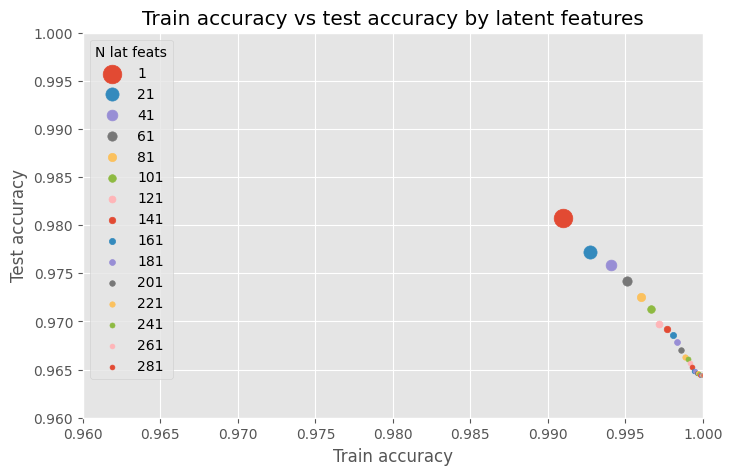

In [90]:
plt.figure(figsize=(8, 5))
for idx, v in enumerate(num_latent_feats):
    plt.scatter(train_accs[idx], test_accs[idx], s=len(num_latent_feats)*5//(idx+1))

plt.title('Train accuracy vs test accuracy by latent features')
plt.xlabel('Train accuracy')
plt.ylabel('Test accuracy')
plt.ylim((0.96,1))
plt.xlim((0.96,1))
plt.legend(num_latent_feats[:15], loc='best', title='N lat feats')
plt.grid(True)
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

In [91]:
# Pearson correlation coefficients of train accuracy to test accuracy
np.corrcoef(train_accs, test_accs)

array([[ 1.        , -0.99628832],
       [-0.99628832,  1.        ]])

In [92]:
# Data imbalance
user_item.sum().sum() / user_item.size

0.009161714792733951

1. The data disbalance between seen and unseen articles shows significant deviation to the unseen side. For every seen article there are >100 unseen articles per active user.
2. Train accuracy and test accuracy by the number of latent features have strong negative correlation.
3. Train accuracy and test accuracy are both high even with the lowest number of latent features.
4. Train accuracy reaches 100% accuracy while test accuracy doesn't that means overfitting.

Recommendations based on the analysis:

    - Fix data disbalance.
        - We can increase the number of users.
            - Organize events to obtain new users.
            - Use media advertisments.
            - Write articles on trending topics.
        - We can increase the number of user interactions.
            - Provide them better recommendations and conduct A/B testing for validation.
            - Improve user interface and conduct A/B testing.        

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [93]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1